In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

import pingouin as pg

from sklearn.preprocessing import LabelEncoder

from causalnex.structure import StructureModel
import networkx as nx

# PyTorchのDAGを使う
from causalnex.structure.pytorch import from_pandas

from causalnex.structure.pytorch.core import NotearsMLP

from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import optuna

# original package
# from lab_tools.pickle_manage import *

import warnings
warnings.simplefilter('ignore')

/home/yarita/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# データ読み込みから前処理

In [2]:
df = pd.read_excel('../data/231010-20_AI用qPCRデータ.xlsx', index_col=0, header=1)
df = df.dropna()
df = df.reset_index(drop=True)
df

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,0.000004,2.982088e-05,0.000004,1.512045e-05,0.000015,9.403729e-07,0.000122,0.000015,4.792578e-07,0.000007,...,0.000008,0.000121,1.193258e-07,0.000119,0.000004,0.000008,0.000015,0.000030,0.000015,0.000030
1,0.000008,3.062644e-05,0.000016,2.940716e-08,0.000015,3.847846e-06,0.000124,0.000015,3.848767e-06,0.000015,...,0.000015,0.000123,2.377373e-07,0.000123,0.000008,0.000016,0.000031,0.000061,0.000031,0.000061
2,0.000008,7.608227e-06,0.000016,1.396326e-08,0.000031,9.615077e-07,0.000245,0.000015,4.864569e-07,0.000031,...,0.000015,0.000122,9.666787e-07,0.000122,0.000008,0.000016,0.000062,0.000062,0.000031,0.000062
3,0.000004,1.513944e-05,0.000015,1.225795e-07,0.000015,4.807837e-07,0.000124,0.000015,1.207673e-07,0.000008,...,0.000015,0.000061,2.410427e-07,0.000061,0.000004,0.000008,0.000031,0.000062,0.000031,0.000062
4,0.000008,4.768491e-07,0.000031,6.105349e-08,0.000031,9.593193e-07,0.000124,0.000015,2.428970e-07,0.000016,...,0.000016,0.000124,4.795912e-07,0.000124,0.000008,0.000008,0.000031,0.000062,0.000031,0.000062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0.000016,1.548460e-05,0.000016,7.811825e-06,0.000032,7.776049e-06,0.000126,0.000008,9.795477e-07,0.000008,...,0.000008,0.000031,6.246519e-05,0.000062,0.000004,0.000004,0.000062,0.000062,0.000008,0.000016
187,0.000031,3.102688e-05,0.000062,1.552830e-05,0.000127,1.566467e-05,0.000124,0.000016,7.839267e-06,0.000008,...,0.000008,0.000062,6.145572e-05,0.000062,0.000008,0.000008,0.000031,0.000125,0.000016,0.000016
188,0.000015,1.523452e-05,0.000016,1.559087e-05,0.000032,3.922552e-06,0.000124,0.000008,9.952745e-07,0.000004,...,0.000008,0.000031,6.206524e-05,0.000062,0.000004,0.000004,0.000031,0.000062,0.000008,0.000015
189,0.000008,1.548722e-05,0.000032,1.568935e-05,0.000063,7.882610e-06,0.000125,0.000008,1.998847e-06,0.000008,...,0.000004,0.000031,6.243563e-05,0.000062,0.000004,0.000004,0.000031,0.000031,0.000008,0.000016


In [3]:
# Normalization
scaler = StandardScaler()
normalized_data_array = scaler.fit_transform(df)

In [4]:
# conversion array to Dataframe
normalized_df = pd.DataFrame(normalized_data_array, columns=df.columns)

# 偏相関係数

In [5]:
# 偏相関行列の計算
partial_corr_matrix = pg.pcorr(normalized_df).round(3)
partial_corr_matrix

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
glk,1.000,0.157,-0.025,-0.030,0.500,0.115,-0.111,0.006,0.201,-0.212,...,0.127,0.162,0.062,-0.142,0.434,0.083,0.134,0.000,-0.190,-0.158
agp,0.157,1.000,0.127,0.145,-0.248,-0.011,0.255,0.093,0.192,0.019,...,0.129,0.056,0.282,0.113,0.032,-0.180,-0.077,0.068,0.177,-0.100
yihX,-0.025,0.127,1.000,0.317,0.156,-0.142,-0.133,0.141,-0.104,0.003,...,0.163,-0.157,-0.029,-0.092,0.098,0.133,0.024,0.187,0.112,-0.240
pgm,-0.030,0.145,0.317,1.000,0.270,-0.177,-0.071,0.113,-0.178,-0.061,...,-0.116,0.349,-0.159,0.027,-0.104,0.098,0.094,-0.075,0.051,0.221
ptsG,0.500,-0.248,0.156,0.270,1.000,0.389,0.184,-0.051,0.048,0.193,...,-0.062,-0.116,0.110,0.044,-0.220,-0.309,-0.088,-0.028,0.015,0.064
malx,0.115,-0.011,-0.142,-0.177,0.389,1.000,-0.170,0.316,0.160,0.044,...,-0.016,0.120,-0.058,0.159,-0.019,0.136,0.148,-0.003,0.197,-0.175
crr,-0.111,0.255,-0.133,-0.071,0.184,-0.170,1.000,0.099,-0.202,0.345,...,0.040,-0.090,-0.161,0.096,0.074,0.105,-0.011,0.190,0.020,0.076
galM,0.006,0.093,0.141,0.113,-0.051,0.316,0.099,1.000,0.026,0.033,...,-0.027,-0.006,0.059,0.068,0.291,0.007,-0.272,-0.063,-0.103,0.287
yihR,0.201,0.192,-0.104,-0.178,0.048,0.160,-0.202,0.026,1.000,0.041,...,-0.038,-0.013,-0.165,-0.084,-0.064,0.140,-0.047,0.105,-0.022,0.133
yeaD,-0.212,0.019,0.003,-0.061,0.193,0.044,0.345,0.033,0.041,1.000,...,-0.324,0.233,0.152,-0.055,0.028,0.146,0.163,-0.178,-0.044,0.015


In [6]:
# # ヒートマップの描画
# plt.figure(figsize=(50, 25))
# sns.set(font_scale = 2)

# ax = sns.heatmap(
#             partial_corr_matrix, 
#             annot=True, 
#             fmt='g', 
#             cmap='Blues', 
#             annot_kws={"size":15}
#             )

# ax.xaxis.tick_top()
# ax.set_xticklabels(ax.get_xticklabels(), rotation=50)

# plt.savefig('./output/heatmap.png')

# パラメータ探索と構造学習

In [7]:
def objective(trial):
    # Optunaでチューニングするハイパーパラメータ
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    threshold = trial.suggest_float('threshold', 0.0, 1.0)
    lasso_beta = trial.suggest_float('lasso_beta', 1e-4, 1e-1, log=True)  # ログスケールでlassoの値を探索
    ridge_beta = trial.suggest_float('ridge_beta', 1e-4, 1e-1, log=True)  # リッジ正則化の係数を探索
    use_bias = trial.suggest_categorical('use_bias', [True, False])

    # StructureModelのインスタンスを作成
    sm = StructureModel()

    # NOTEARSアルゴリズムを用いて構造学習を実施
    # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
    sm, loss_value = from_pandas(normalized_df, 
                                 max_iter=max_iter,
                                 w_threshold=threshold,
                                 lasso_beta=lasso_beta,
                                 ridge_beta=ridge_beta,
                                 use_bias=use_bias,
                                 )

    # 学習された構造のスコアを計算（スコアリング方法はプロジェクトにより異なる）
    score = calculate_score(sm)

    return score

# スコアリング関数（例：エッジ数でスコアリング）
def calculate_score(sm):
    return -len(sm.edges)  # エッジの数が少ないほどスコアが高くなるように設定

In [8]:
study = optuna.create_study(direction='maximize')  # スコアを最大化するように設定
study.optimize(objective, n_trials=100)  # 100回の試行で最適化

# 最適なハイパーパラメータを出力
print(study.best_params)

[I 2023-11-10 17:04:44,820] A new study created in memory with name: no-name-00d6d003-e22e-412c-9d34-d7c191d82504
[I 2023-11-10 17:04:57,943] Trial 0 finished with value: -443.0 and parameters: {'max_iter': 819, 'threshold': 0.02792450095073762, 'lasso_beta': 0.0032591661652717017, 'ridge_beta': 0.08283667868994163, 'use_bias': False}. Best is trial 0 with value: -443.0.
[I 2023-11-10 17:05:11,373] Trial 1 finished with value: -277.0 and parameters: {'max_iter': 602, 'threshold': 0.15986737077531843, 'lasso_beta': 0.00041828444556440904, 'ridge_beta': 0.00013600901898521372, 'use_bias': True}. Best is trial 1 with value: -277.0.
[I 2023-11-10 17:05:24,320] Trial 2 finished with value: -119.0 and parameters: {'max_iter': 902, 'threshold': 0.3760958200294967, 'lasso_beta': 0.00040721340907437417, 'ridge_beta': 0.029676102152775205, 'use_bias': False}. Best is trial 2 with value: -119.0.
[I 2023-11-10 17:05:36,904] Trial 3 finished with value: -108.0 and parameters: {'max_iter': 560, 'thr

In [ ]:
study.best_params

{'max_iter': 713,
 'threshold': 0.9989188747112954,
 'lasso_beta': 0.09265029283859945,
 'ridge_beta': 0.001224291551572592,
 'use_bias': True}

In [ ]:
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
# 最適な閾値を取得
best_max_iter = study.best_params['max_iter']
best_threshold = study.best_params['threshold']
my_driven_hidden_layer_units = [1] # 1回と2回でtry
best_lasso_beta = study.best_params['lasso_beta']
best_ridge_beta = study.best_params['ridge_beta']
best_use_bias = study.best_params['use_bias']

# 最適な閾値で構造学習を実施
best_sm, loss_value = from_pandas(normalized_df,
                                  max_iter=best_max_iter,
                                  w_threshold=best_threshold,
                                  hidden_layer_units=my_driven_hidden_layer_units,
                                  lasso_beta=best_lasso_beta,
                                  ridge_beta=best_ridge_beta,
                                  use_bias=best_use_bias,
                                  )

In [ ]:
# 損失関数の出力
loss_value

16.5000002682209

In [ ]:
best_sm.threshold_till_dag()

In [ ]:
best_sm.nodes

NodeView(('glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA'))

In [ ]:
edge_width = [d["weight"]*1 for (u, v, d) in best_sm.edges(data=True)]
sm_l = best_sm.get_largest_subgraph()

In [ ]:
sm_l

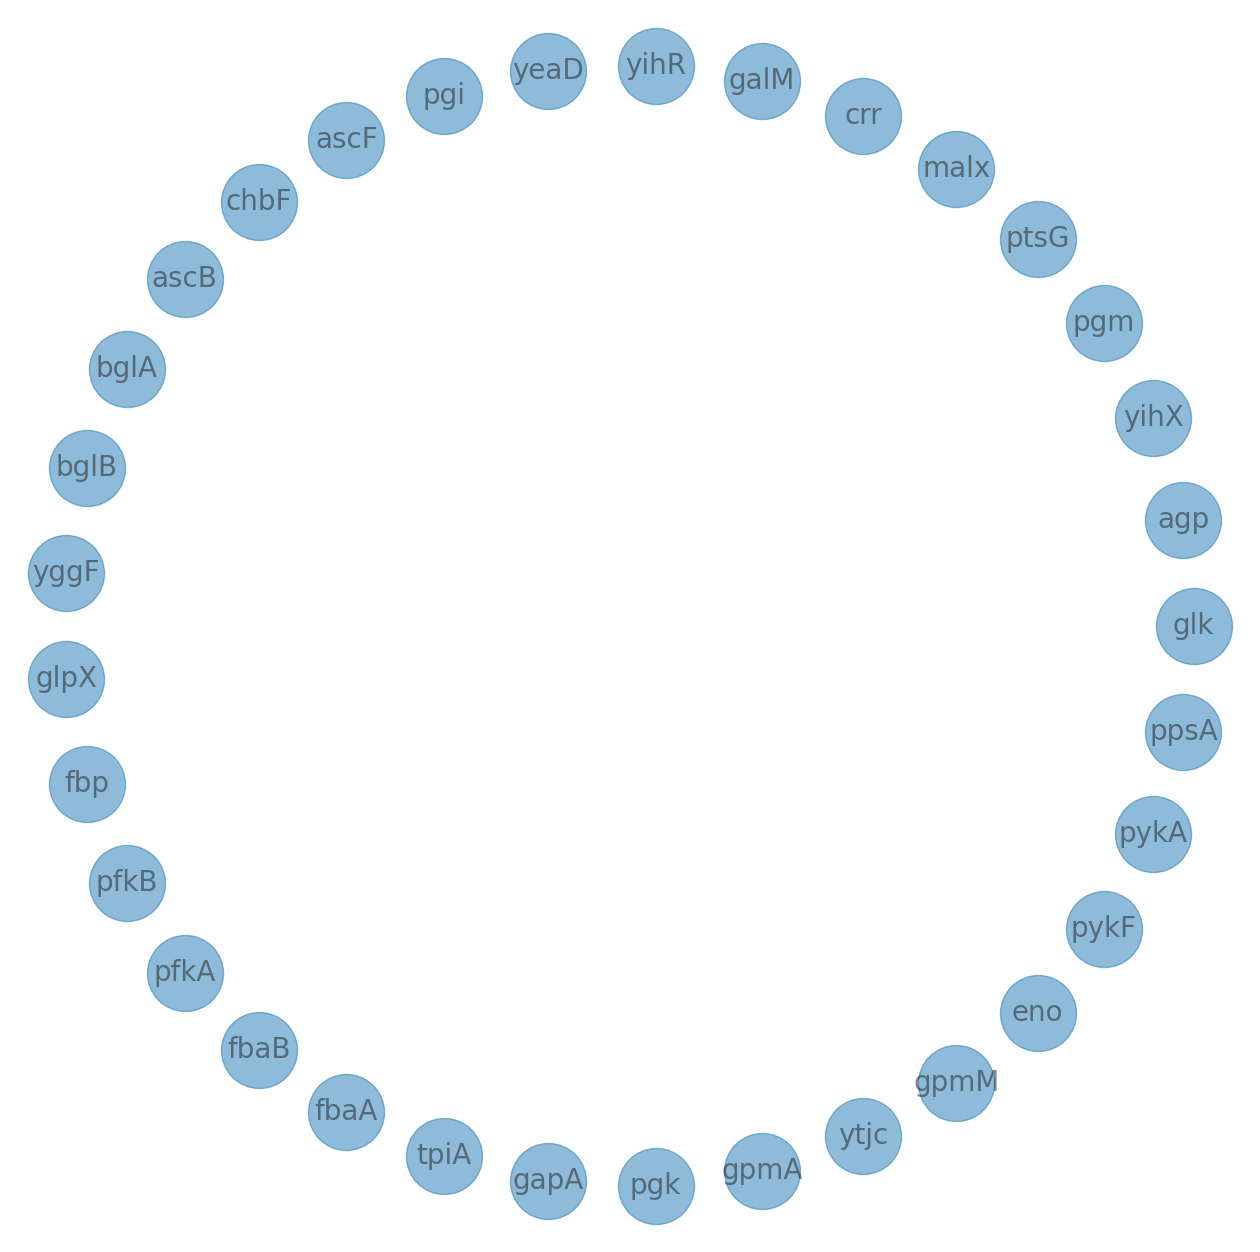

In [ ]:
# ネットワーク図を描画
fig, ax = plt.subplots(figsize=(16,16))
nx.draw_circular(best_sm,
                 with_labels=True,
                 font_size=20,
                 node_size=3000,
                 arrowsize=20,
                 alpha=0.5,
                 width=edge_width,
                 ax=ax)
plt.plot()
plt.savefig("./output/best_network.png", format="png", dpi=300)

In [ ]:
# オブジェクトを保存
# output_object(sm_l, "sm.pickle", "./")

In [ ]:
best_threshold

0.9989188747112954

[]

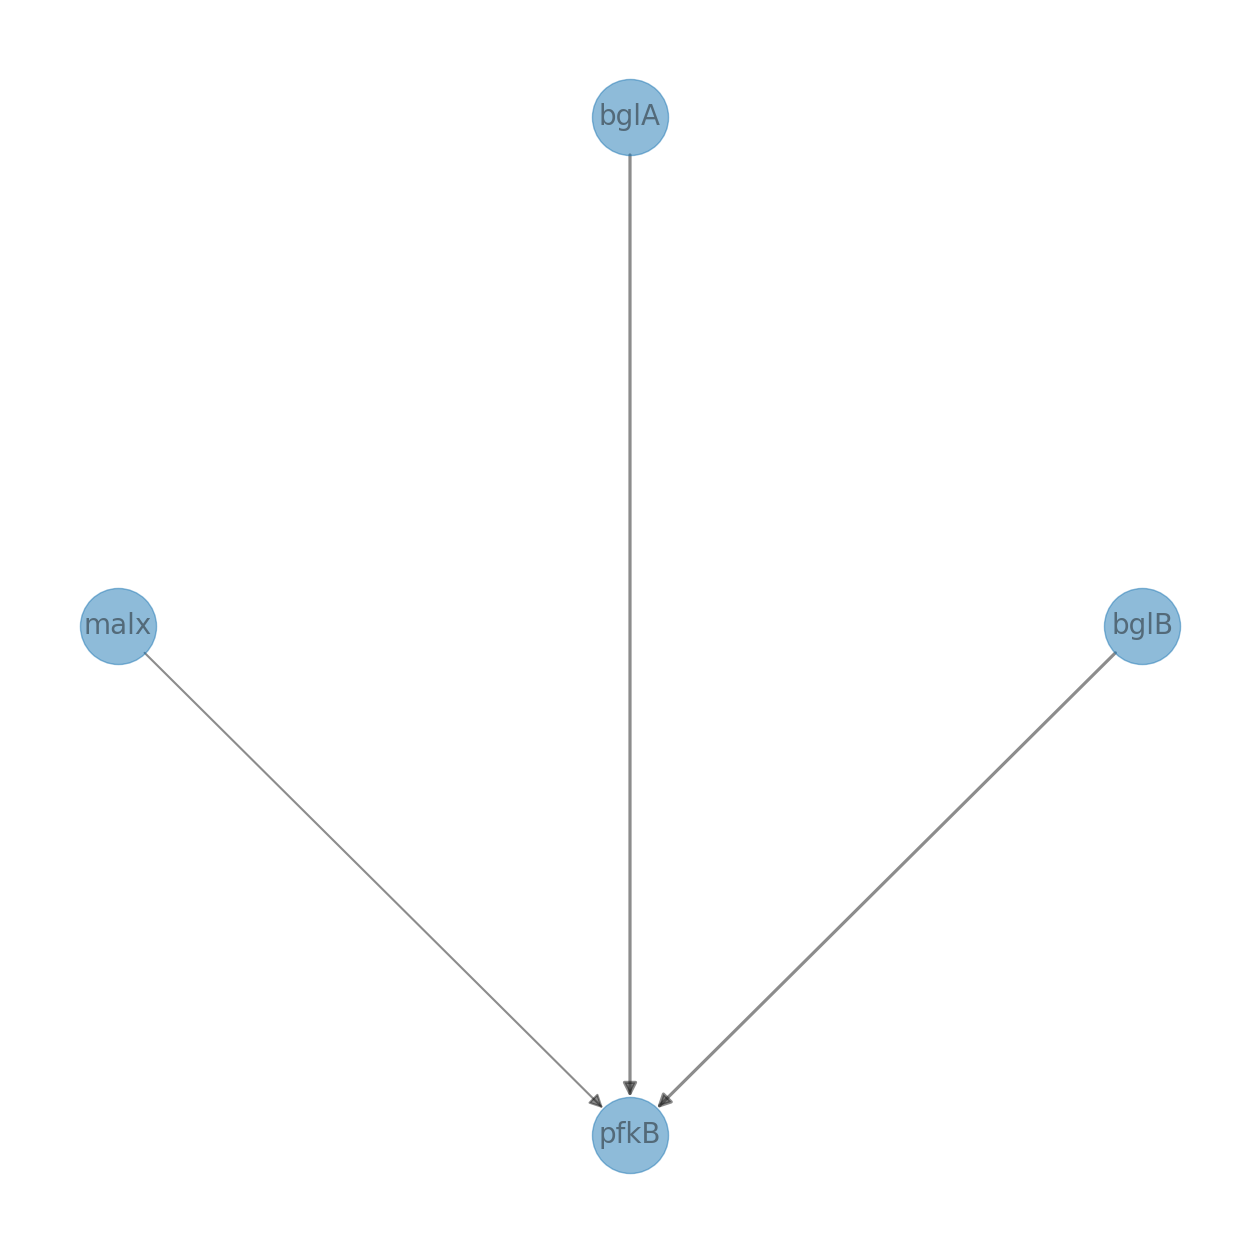

In [ ]:
# 閾値を設定し、残すエッジを決める
# best_sm.remove_edges_below_threshold(best_threshold)

# エッジが伸びてないノードを消す
# edge_width = [ d["weight"]*1 for (u, v, d) in best_sm.edges(data=True)]
# sm_l = best_sm.get_largest_subgraph()

# ネットワーク図を描画
fig, ax = plt.subplots(figsize=(16,16))
nx.draw_circular(sm_l,
                 with_labels=True,
                 font_size=20,
                 node_size=3000,
                 arrowsize=20,
                 alpha=0.5,
                 width=edge_width,
                 ax=ax)
# plt.plot()

# ベイジアンネットワーク

## 離散化処理

In [ ]:
# モデルのインスタンス化
bn = BayesianNetwork(sm_l)
# sm_lネットワークのノードに対応する列だけを選択し，あらたなデータセットとして定義
discretised_data = df[[x for x in sm_l.nodes]]
# dfの各列に関してその列のユニークな値を辞書形式で取得している．
# これにより，後で値を離散化する際の基準となる値の集合を得る．
data_vals = {col: df[col].unique() for col in df.columns}

NameError: name 'test' is not defined

In [ ]:
bn = BayesianNetwork(sm_l)

## 離散化処理

In [ ]:
# DAGに存在しているノードのみのデータフレームを作成
discretised_data = struct_data[[x for x in sm_l.nodes]]
# # 列ごとのユニークな値を辞書のValueとして登録
# data_vals = {col: data[col].unique() for col in data.columns}
# # 0: no-failure, 1~3: have-failureとする
# failures_map = {v: "no-failure" if v == [0] else "have-failure" 
#                 for v in data_vals["failures"]}
# # 1~2:short-studytime, 3~4:long-studytimeとする 
# studytime_map = {v: "short-studytime" if v in [1,2] else "long-studytime"
#                  for v in data_vals["studytime"]}
# # 上二つのマッピングを実行
# discretised_data["failures"] = discretised_data["failures"].map(failures_map)
# discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

# # 離散化処理を行う
# # uniform: 均一に分割
# # quantile: 分位数で分割
# # fixed: numeric_split_pointsで指定した値で分割
# discretised_data["absences"] = Discretiser(method="fixed",
#                                           numeric_split_points=[1,10]).transform(discretised_data["absences"].values)
# discretised_data["G1"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G1"].values)
# discretised_data["G2"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G2"].values)
# discretised_data["G3"] = Discretiser(method="fixed",
#                           numeric_split_points=[10]).transform(discretised_data["G3"].values)

# # 離散化したデータをマッピングする
# absences_map = {0: "No-absence", 1:"Low-absence", 2:"High-absence"}
# G1_map = {0: "Fail", 1: "Pass"}
# G2_map = {0: "Fail", 1: "Pass"}
# G3_map = {0: "Fail", 1: "Pass"}
# discretised_data["absences"] = discretised_data["absences"].map(absences_map)
# discretised_data["G1"] = discretised_data["G1"].map(G1_map)
# discretised_data["G2"] = discretised_data["G2"].map(G2_map)
# discretised_data["G3"] = discretised_data["G3"].map(G3_map)

discretised_data

NameError: name 'struct_data' is not defined

In [ ]:
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1)

In [ ]:
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train)

In [ ]:
bn.cpds["glk"]

ppsA,0,1,2,3
glk,,,,
0,0.310345,0.166667,0.370370,0.161290
1,0.137931,0.333333,0.148148,0.322581
2,0.379310,0.266667,0.222222,0.225806
3,0.172414,0.233333,0.259259,0.290323


# 評価

In [ ]:
predictions = bn.predict(discretised_data, "glk")
print(discretised_data.loc[1, "glk"])

In [ ]:
display(classification_report(bn, test, "glk"))

{'glk_0': {'precision': 0.4,
  'recall': 0.5,
  'f1-score': 0.4444444444444445,
  'support': 4},
 'glk_1': {'precision': 0.4,
  'recall': 0.4,
  'f1-score': 0.4000000000000001,
  'support': 5},
 'glk_2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'glk_3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 'accuracy': 0.2857142857142857,
 'macro avg': {'precision': 0.2,
  'recall': 0.225,
  'f1-score': 0.21111111111111114,
  'support': 14},
 'weighted avg': {'precision': 0.2571428571428572,
  'recall': 0.2857142857142857,
  'f1-score': 0.2698412698412699,
  'support': 14}}

In [ ]:
for n in bn.nodes:
    roc, auc = roc_auc(bn, test, n)
    print(n, auc)

galM 0.7891156462585034
crr 0.7908163265306123
tpiA 0.8231292517006803
yihR 0.8894557823129252
malx 0.8435374149659863
bglB 0.9047619047619047
pgi 0.30952380952380953
gpmA 0.8886054421768708
ppsA 0.641156462585034
ascB 0.7891156462585035
fbaB 0.7576530612244897
yggF 0.8443877551020408
glpX 0.7738095238095237
gapA 0.8333333333333334
fbp 0.8027210884353742
fbaA 0.7414965986394557
pykA 0.9251700680272109
gpmM 0.7210884353741497
glk 0.5153061224489796
